## OVERVIEW
---
* Image Preprocessing
* Transfer Learning with Pretrained models
* Bottleneck Feature Extraction
* Deep Learning Model

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/b944a49ca.png
/kaggle/input/plant-seedlings-classification/test/30ad31220.png
/kaggle/input/plant-seedlings-classification/test/668c1007c.png
/kaggle/input/plant-seedlings-classification/test/3526b05cc.png
/kaggle/input/plant-seedlings-classification/test/b4f7c9214.png
/kaggle/input/plant-seedlings-classification/test/a93f940d6.png
/kaggle/input/plant-seedlings-classification/test/851c90831.png
/kaggle/input/plant-seedlings-classification/test/0021e90e4.png
/kaggle/input/plant-seedlings-classification/test/aa7d098d1.png
/kaggle/input/plant-seedlings-classification/test/bf3924a57.png
/kaggle/input/plant-seedlings-classification/test/9516e56c4.png
/kaggle/input/plant-seedlings-classification/test/a890ac088.png
/kaggle/input/plant-seedlings-classification/test/86f08e6d1.png
/kaggle/input/plant-seedlings-classification/test/ba3ce6b3e.png
/kaggle/input/plant-seedlings-classif

In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
base_folder = '../input/plant-seedlings-classification'
train_data_folder = os.path.join(base_folder, 'train')

#get the plant categories
categories = os.listdir(train_data_folder)
abbreviations = ['LSB', 'SP', 'FH', 'Ch', 'SB', 'Ma', 'CW', 'Cl', 'BG', 'SFC', 'SM', 'CC']
len_categories = len(categories)


In [4]:
#read the images from train folder
image_count = {}
train_data = []
for i, plant in tqdm(enumerate(categories)):
    plant_folder_name = os.path.join(train_data_folder, plant)
    plant_name = plant
    image_count[plant] = []
    for path in os.listdir(os.path.join(plant_folder_name)):
        image_count[plant].append(plant)
        train_data.append(['train/{}/{}'.format(plant, path), i, plant])
#create a dataframe
train_img = pd.DataFrame(train_data, columns=['filepath', 'id', 'class'])

12it [00:00, 720.84it/s]


In [5]:
#read the images from test folder

test_data = []

for file in os.listdir('../input/plant-seedlings-classification/test'):
    test_data.append(['test/{}'.format(file), file])
test_data = pd.DataFrame(test_data, columns=['filepath', 'filename'])

print('SHAPE OF TEST DATA: ', test_data.shape)
#show dataframe
test_data.head()

SHAPE OF TEST DATA:  (794, 2)


,filepath,filename
0,test/b944a49ca.png,b944a49ca.png
1,test/30ad31220.png,30ad31220.png
2,test/668c1007c.png,668c1007c.png
3,test/3526b05cc.png,3526b05cc.png
4,test/b4f7c9214.png,b4f7c9214.png


In [6]:
#show image count per class
for key,value in image_count.items():
    print("{0} -> {1} images".format(key, len(value)))

Shepherds Purse -> 231 images
Common Chickweed -> 611 images
Common wheat -> 221 images
Sugar beet -> 385 images
Maize -> 221 images
Fat Hen -> 475 images
Loose Silky-bent -> 654 images
Black-grass -> 263 images
Scentless Mayweed -> 516 images
Small-flowered Cranesbill -> 496 images
Cleavers -> 287 images
Charlock -> 390 images


In [7]:
#show dataframe
train_img.head()

,filepath,id,class
0,train/Shepherds Purse/a4ae6ec8b.png,0,Shepherds Purse
1,train/Shepherds Purse/f90b0ca05.png,0,Shepherds Purse
2,train/Shepherds Purse/ffb54800c.png,0,Shepherds Purse
3,train/Shepherds Purse/97bfbdcf0.png,0,Shepherds Purse
4,train/Shepherds Purse/fe3bcb925.png,0,Shepherds Purse


In [8]:
#show number of images
train_img.shape[0]

4750

In [9]:
#get image samples per class and label them as traning data
sample_per_class = 200
train_data = pd.concat(train_img[train_img['class']==label][:sample_per_class] for label in categories ).sample(frac=1)
#rest the index
train_data.index = np.arange(train_data.shape[0])

In [10]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(base_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGE

Text(0.5, 0.98, 'SAMPLE IMAGES')

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

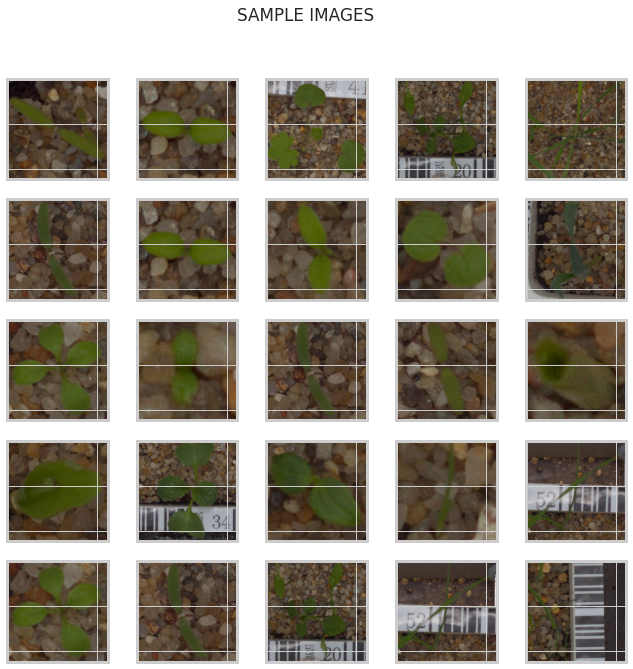

In [11]:
#show sample images
nb_rows = 5
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))
plt.suptitle('SAMPLE IMAGES')
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((read_img(train_data['filepath'][np.random.randint(100)], (224,224)))/255.)

### XCEPTION FEATURE EXTRACTION

In [12]:
INPUT_SIZE = 255
X_train  = np.zeros((len(train_data), INPUT_SIZE, INPUT_SIZE, train_data.shape[1]), dtype='float')

for i, file in tqdm(enumerate(train_data['filepath'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_train[i] = x

2400it [00:44, 53.53it/s]


In [13]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (2400, 255, 255, 3)
Train Image Size:  468180000


#### SPLIT THE DATA

In [14]:
y = to_categorical(train_data['id'])
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [15]:
xception_b  = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_b.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_b.predict(train_val, batch_size=32, verbose=1)

15/15 [==============================] - 1s 96ms/step


In [16]:
print('TRAIN DATA SHAPE: ', bf_train_x.shape)
print('TRAIN DATA SIZE: ', bf_train_x.size)
print('VALIDATION DATA SHAPE: ', bf_train_val.shape)
print('VALIDATION DATA SIZE: ', bf_train_val.size)

TRAIN DATA SHAPE:  (1920, 2048)
TRAIN DATA SIZE:  3932160
VALIDATION DATA SHAPE:  (480, 2048)
VALIDATION DATA SIZE:  983040


### PREDICTIVE MODELLING

In [17]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = len_categories, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 541,772
Trainable params: 541,772
Non-trainable params: 0
_________________________________________________________________


In [18]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=200, batch_size=32)

Epoch 1/200
60/60 [==============================] - 0s 2ms/step - loss: 1.7564 - accuracy: 0.4036
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.8918 - accuracy: 0.6948
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5935 - accuracy: 0.7911
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.8479
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.3594 - accuracy: 0.8823
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.9010
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.2449 - accuracy: 0.9219
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9417
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.9563
Epoch 10/200
60/60 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.9672
Epoch 11/

#### TRAINING LOSS AND ACCURACY

Text(0.5, 1.0, 'TRAINING LOSS')

Text(0.5, 1.0, 'TRAINING ACCURACY')

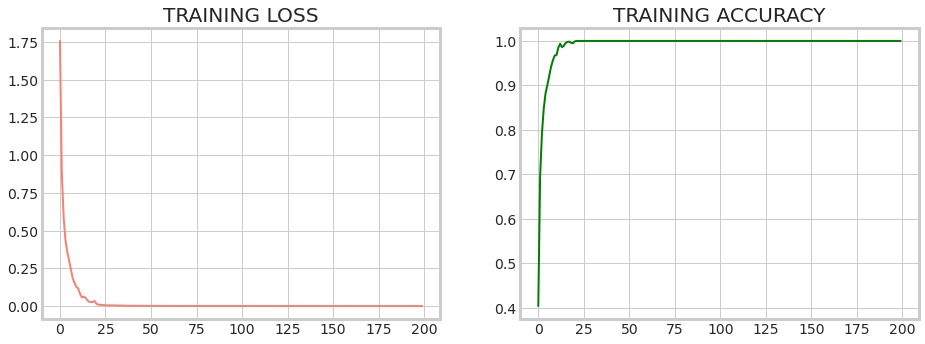

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')


ax[0].plot(history.history['loss'], color= 'salmon',lw=2)
ax[1].plot(history.history['accuracy'], color= 'green',lw=2)

In [20]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)
y_true = y_val.argmax(1)

In [21]:
#print classification report
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        33
           1       0.83      0.76      0.80        46
           2       0.66      0.75      0.70        28
           3       0.90      0.86      0.88        42
           4       0.91      0.95      0.93        41
           5       0.81      0.75      0.78        51
           6       0.79      0.76      0.77        45
           7       0.66      0.68      0.67        40
           8       0.81      0.75      0.78        40
           9       0.80      0.89      0.84        36
          10       0.97      0.94      0.96        35
          11       0.93      0.91      0.92        43

    accuracy                           0.81       480
   macro avg       0.81      0.82      0.81       480
weighted avg       0.82      0.81      0.82       480



<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'CONFUSION MATRIX')

Text(0.5, 28.899999999999963, 'True Class')

Text(64.9, 0.5, 'Predicted Class')

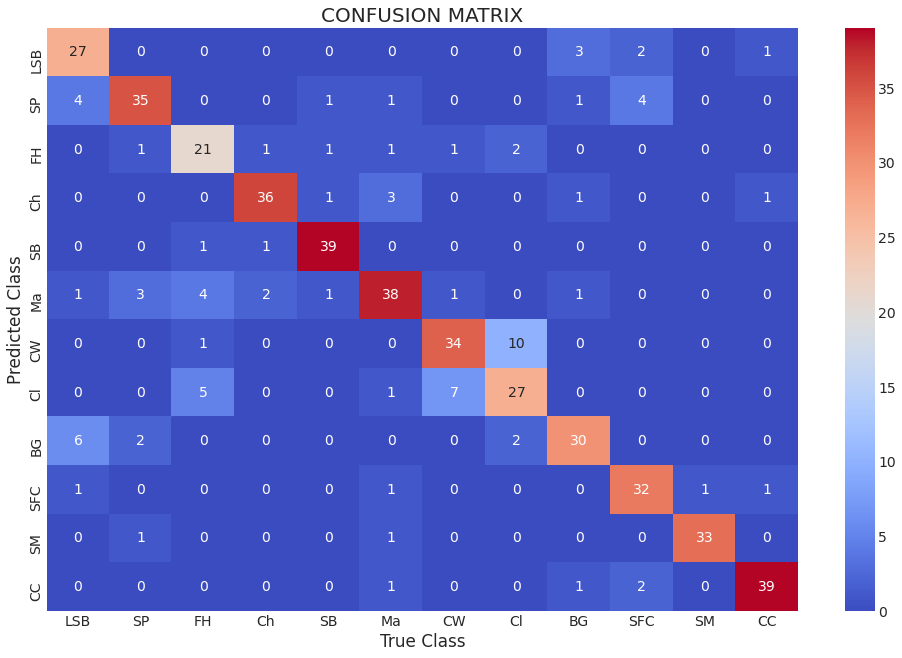

In [22]:
#confusion matrix
con_mat = confusion_matrix(y_true, predictions)

plt.figure(figsize=(15,10))
plt.title('CONFUSION MATRIX', fontsize=20)

sns.heatmap(con_mat, cmap='coolwarm', yticklabels=abbreviations, xticklabels=abbreviations, annot=True)
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

plt.savefig('Confusion Matrix.png', dpi=480)

### SUBMISSION

In [23]:
X_test = np.zeros((len(test_data), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test_data['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_test[i] = x

794it [00:06, 129.35it/s]


In [24]:
bf_test = xception_b.predict(X_test, batch_size=32, verbose=1)
test_prediction = model.predict_classes(bf_test)

25/25 [==============================] - 3s 110ms/step


In [25]:
submission = pd.DataFrame(columns=['file', 'species'])
submission['file'] = test_data['filename']
submission['species'] = [categories[i] for i in test_prediction]

submission.to_csv('submission.csv', index=False)